<a href="https://colab.research.google.com/github/AsalNouri/Fall-2020/blob/master/Biostatistics_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Seed Classification

How will you classify the bellow two images?

![1rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg) Proper Shaped Rice Seed

![2rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg) Broken Rice Seed



In [1]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
#creates a confusion matrix 
def plot_confusion_matrix(cm, classes,                          
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    #code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:

!apt-get install subversion > /dev/null
!svn export https://github.com/totti0223/deep_learning_for_biologists_with_keras/trunk/notebooks/data/image image > /dev/null

In [4]:
#Inspects part of the files downloaded from the address above
!ls image
!ls image/train
!ls image/train/broken #prints 

test  test.txt	train  train.txt
broken	proper
141.jpg  177.jpg  213.jpg  248.jpg  274.jpg  300.jpg  326.jpg  352.jpg	378.jpg
142.jpg  178.jpg  214.jpg  249.jpg  275.jpg  301.jpg  327.jpg  353.jpg	379.jpg
144.jpg  179.jpg  215.jpg  250.jpg  276.jpg  302.jpg  328.jpg  354.jpg	380.jpg
145.jpg  180.jpg  216.jpg  251.jpg  277.jpg  303.jpg  329.jpg  355.jpg	381.jpg
147.jpg  182.jpg  217.jpg  252.jpg  278.jpg  304.jpg  330.jpg  356.jpg	382.jpg
150.jpg  184.jpg  218.jpg  253.jpg  279.jpg  305.jpg  331.jpg  357.jpg	383.jpg
152.jpg  185.jpg  219.jpg  254.jpg  280.jpg  306.jpg  332.jpg  358.jpg	384.jpg
155.jpg  186.jpg  220.jpg  255.jpg  281.jpg  307.jpg  333.jpg  359.jpg	385.jpg
156.jpg  189.jpg  221.jpg  256.jpg  282.jpg  308.jpg  334.jpg  360.jpg	386.jpg
158.jpg  191.jpg  222.jpg  257.jpg  283.jpg  309.jpg  335.jpg  361.jpg	387.jpg
160.jpg  194.jpg  223.jpg  258.jpg  284.jpg  310.jpg  336.jpg  362.jpg	388.jpg
161.jpg  195.jpg  224.jpg  259.jpg  285.jpg  311.jpg  337.jpg  363.jpg	389.jpg
162.jp

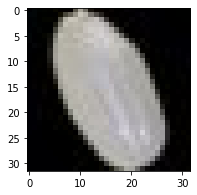

In [5]:
#Tries one image
image = imread("image/train/proper/100.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [6]:
#load training dataset
X_train = []
y_train = []

for root, dirs, files in os.walk("image/train"): #load training dataset from github
    files = [x for x in files if x.endswith(".jpg")] #Adds the images
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.             
        image = resize(image,(28,28))              #Resizing the image to a smaller size to save storage
        X_train.append(image)        
        category = os.path.split(root)[-1]         
        if category == "proper":                    #Assign zero to the images labeled "proper" and one to the ones labeled broken
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)



X_test = []
y_test = []

for root, dirs, files in os.walk("image/test"):             #Gets test dataset from the image/test folder
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(28,28))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("train dataset shape is:", X_train.shape,y_train.shape)
print("test dataset shape is:", X_test.shape,y_test.shape)

train dataset shape is: (377, 28, 28, 3) (377,)
test dataset shape is: (20, 28, 28, 3) (20,)


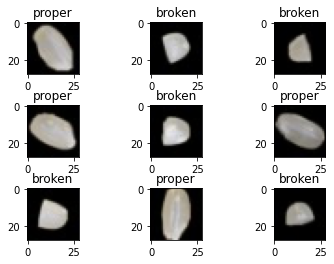

In [7]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

index = np.random.randint(0,X_train.shape[0],size=9) #plots random 9 images from the train dataset

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "proper"
    else:
        label = "broken"
    plt.title(label)
    plt.imshow(X_train[idx])

(28, 28, 3)


Text(0.5, 1.0, 'original')

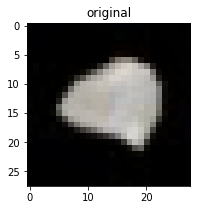

In [8]:
#Tries an image
image = X_train[120]

#the original image
print(image.shape)
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title("original")

(28, 28)


Text(0.5, 1.0, 'gray converted')

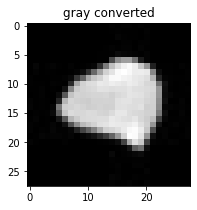

In [9]:
#Converts to gray
gray = rgb2gray(image)
print(gray.shape)
plt.figure(figsize=(3,3))
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("gray converted")

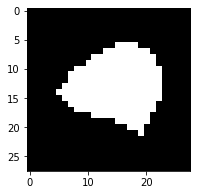

In [10]:
#converts to black and white
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.figure(figsize=(3,3))
plt.imshow(binary, cmap=plt.cm.gray)

now that we have a nice binary image, we can isolate the region of rice seed which corresponds to the white region of the image above.

In [11]:
label_im, nb_labels = ndimage.label(binary)
regionprops = measure.regionprops(label_im, intensity_image=gray) #using skimage library functions to find the major and minor axis and area of the rice grains
regionprop = regionprops[0]

print("area is",regionprop.area)
print("major axis length is", regionprop.major_axis_length)
print("minor axis length is", regionprop.minor_axis_length)

area is 183
major axis length is 17.235511208163985
minor axis length is 14.118947913934065


In [12]:
X_train_area = []
X_train_ratio = []
for image in X_train:
    area, r = quant_area_ratio(image)
    X_train_area.append(area)
    X_train_ratio.append(r)

X_test_area = []
X_test_ratio = []
for image in X_test:
    area, r = quant_area_ratio(image)
    X_test_area.append(area)
    X_test_ratio.append(r)


NameError: ignored

In [ ]:
#Plots broken grains red and proper ones blue based on major to minor axis ratio
plt.scatter(X_train_ratio,X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

In [ ]:
#Plots broken (red)and proper (blue from the test dataset)
plt.scatter(X_test_ratio,X_test_area,c=y_test,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

In [ ]:
#create a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

area  = quantify_area(image)
print(area)

In [ ]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

In [ ]:
#check the area of training dataset
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

In [ ]:
#set a treshhold to separate classes
area_threshold = 256


#classify grains to broken or proper
train_y_pred = []
for area in X_train_area:
    if area > area_threshold:
        train_y_pred.append(0)
    else:
        train_y_pred.append(1)
        

#Scater plot with the threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
plt.title("blue:proper seed, red: broken seed")
plt.show()

#Confusion matrix calculation
cnf = confusion_matrix(y_train, train_y_pred)

plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])

plt.show()

In [ ]:
test_y_pred = []
for area in X_test_area:
    if area > area_threshold:
        test_y_pred.append(0)
    else:
        test_y_pred.append(1)
        
#Scatter plot with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_test_area)),X_test_area,c=y_test,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#Confusion matrix calculation
cnf = confusion_matrix(y_test, test_y_pred)

plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

In [ ]:
#builds a classifier

def manual_classifier(image,area_threshold):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    if area > area_threshold:
        return 0
    else:
        return 1

# getPick an image from test dataset 
n = 12
image = X_test[n]
label = y_test[n]
area_threshold = 275 #We changed the threshold value 275 for more accuracy
prediction = manual_classifier(image,area_threshold)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)